In [141]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [142]:
# read in all words
words = open("names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [143]:
len(words)

32033

In [144]:
# build the vector point of characters and mapping to/from integers
chars = sorted(set(''.join(words)))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print("size of characters :", vocab_size)

size of characters : 27


In [154]:
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [145]:
block_size = 3
# build the dataset
def build_dataset(words):
    # context length: how many characters do we take to predict next one?
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [146]:
# MLP revisited
n_embd = 10     # dimensionality of character embedding vectors
n_hidden = 200  # number of neurons in the hidden layer of MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn([vocab_size, n_embd], generator=g)
W1 = torch.randn([n_embd * block_size, n_hidden], generator=g) * (5/3) / ((n_embd * block_size) ** 0.5) #* 0.2
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn([n_hidden, vocab_size], generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.zeros((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True
print("number of parameters: ", sum(p.nelement() for p in parameters))

number of parameters:  12097


In [147]:
# optimization
max_steps = 200000
batch_size = 32
lossi = []
for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))  # (batch_size)
    Xb, Yb = Xtr[ix], Ytr[ix]   # Xb: (batch_size, block_size)
    
    # forward pass
    emb = C[Xb] # embed the characters to vectors, (batch_size, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) 
    hpreact = embcat @ W1 #+ b1
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    h = torch.tanh(hpreact)    # hidden layer
    logits = h @ W2 + b2    # output layer
    loss = F.cross_entropy(logits, Yb)  # logits.exp():e -> e/e.sum(1, keepdim=True):probs -> -probs[torch.arange(batch_size), Yb].log().mean()
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    # backward pass
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}:{loss.item():4f}')
    lossi.append(loss.log10().item())
    

      0/ 200000:3.310346
  10000/ 200000:2.229653
  20000/ 200000:2.246825
  30000/ 200000:2.552459
  40000/ 200000:2.204234
  50000/ 200000:2.169604
  60000/ 200000:2.167585
  70000/ 200000:2.463525
  80000/ 200000:2.188185
  90000/ 200000:2.306082
 100000/ 200000:1.938767
 110000/ 200000:2.355447
 120000/ 200000:2.170582
 130000/ 200000:1.912776
 140000/ 200000:2.189395
 150000/ 200000:2.163670
 160000/ 200000:2.147319
 170000/ 200000:2.347926
 180000/ 200000:2.014018
 190000/ 200000:2.073076


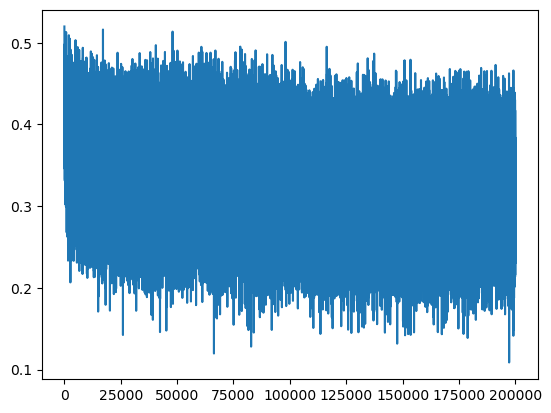

In [148]:
plt.plot(lossi)

In [149]:
# calibrate the batch norm at the end of training
with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1# + b1
    # measure the mean/std of over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [150]:
@torch.no_grad()    # this decorator disables  gradient tracking
def split_loss(split):
    x, y = {
        'train':(Xtr, Ytr),
        'test':(Xte, Yte),
        'val':(Xdev, Ydev)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 # + b1
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0693633556365967
val 2.110264778137207


In [151]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(20):
    out = []
    context = [0] * block_size # initialize with ...
    while True:
        emb = C[torch.tensor([context])]
        embcat = emb.view(emb.shape[0], -1)
        hpreact = embcat @ W1 # + b1
        hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()  
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

mon.
ammyah.
see.
madhayla.
rethrette.
ramir.
derydielin.
shi.
jenleigh.
estanar.
kayzion.
kalin.
shabergshiriel.
kindreelynn.
novana.
uberteder.
yarue.
eli.
kayshayne.
daihaan.
